In [1]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline

In [2]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import geometry
import shapely.speedups
from tqdm import tqdm
from quetzal.model import stepmodel
from quetzal.engine import engine
from quetzal.io import excel
import matplotlib.pyplot as plt

# Preparation of the LoS tables
## Saves a StepModel with shortest paths and LoS attributes for the road network
## Needs the road network

In [3]:
input_path = '../input_static/'
output_path = '../output/'
model_path = '../model/' + scenario + '/'

In [4]:
# Create a path for scenario-specific model files
if not os.path.exists(model_path):
    os.makedirs(model_path)

In [5]:
# Load scenario parameters
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

In [6]:
sm = stepmodel.read_json(input_path + 'de_road_network')
try:
    ae = stepmodel.read_json(model_path + 'de_road_access_egress')
except FileNotFoundError:
    ae = stepmodel.read_json(model_path.replace(scenario, 'base') + 'de_road_access_egress')
try:
    z = stepmodel.read_json(model_path + 'de_zones')
except FileNotFoundError:
    z = stepmodel.read_json(model_path.replace(scenario, 'base') + 'de_zones')

In [7]:
sm.zone_to_road = ae.zone_to_road
sm.centroids = gpd.GeoDataFrame(ae.centroids)
sm.zones = gpd.GeoDataFrame(z.zones)
sm.road_links = gpd.GeoDataFrame(sm.road_links)
sm.road_nodes = gpd.GeoDataFrame(sm.road_nodes)

In [8]:
len(sm.zone_to_road.loc[sm.zone_to_road['a'].str.startswith('DE'), 'a'].unique())

2217

## Generate LoS attribute time
The maxspeed column is based on OSM data that needs to be refined. The unit is km/h

In [9]:
# Road types
sm.road_links['highway'].unique()

array(['motorway_link', 'motorway', 'primary', 'trunk', 'trunk_link',
       'primary_link', 'secondary', 'secondary_link', 'car_train'],
      dtype=object)

array([[<Axes: title={'center': 'maxspeed'}>]], dtype=object)

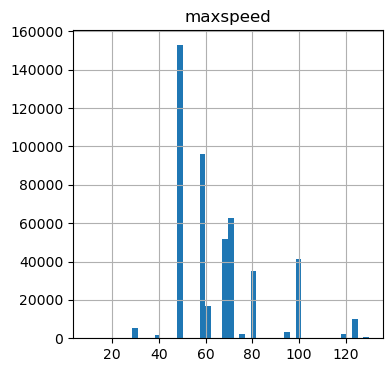

In [10]:
# Number of links (not length) with specified speeds before applying speed limits from params
sm.road_links.hist(column='maxspeed', bins=50, figsize=(4,4))

In [11]:
# Speed limits before applying speed limits from params
sm.road_links['maxspeed'].unique()

array([ 81.        ,  76.        ,  70.        ,  60.        ,
       125.        , 100.        ,  68.        ,  58.        ,
        80.        ,  50.        , 120.        ,  40.        ,
        96.        ,  30.        , 130.        ,  90.        ,
        10.        ,  20.        ,  65.        ,   9.16666667])

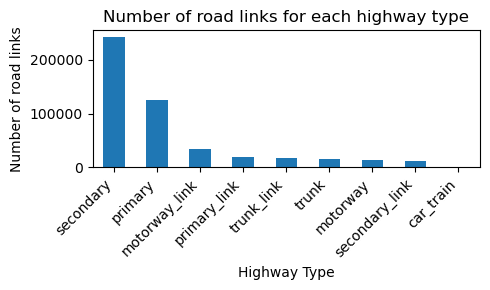

In [12]:
# Number of road links for each highway type
counts = sm.road_links['highway'].value_counts()
# Create a bar plot
plt.figure(figsize=(5, 3))
counts.plot(kind='bar')
plt.title('Number of road links for each highway type')
plt.xlabel('Highway Type')
plt.ylabel('Number of road links')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()

In [13]:
# Find road nodes in cities
shapely.speedups.enable()
urban_zones = sm.zones.loc[sm.zones['urbanisation']==1, 'geometry']
urban_nodes = []
for geo in tqdm(urban_zones, total=len(urban_zones)):
    urban_nodes.append(list(set(sm.road_nodes.loc[sm.road_nodes['geometry'].within(geo)].index)))

100%|█████████████████████████████████████████| 173/173 [00:08<00:00, 21.19it/s]


In [14]:
# Flatten the list of road nodes in cities
urban_nodes_flat = [item for sublist in urban_nodes for item in sublist]

In [15]:
# Set maximum speed limit for urban roads
mask_urban = (sm.road_links['a'].isin(urban_nodes_flat)) & \
             (sm.road_links['b'].isin(urban_nodes_flat)) & \
             (sm.road_links['highway'].isin(['primary', 'primary_link', 'secondary', 'secondary_link']))
sm.road_links.loc[mask_urban, 'maxspeed'] = sm.road_links.loc[mask_urban, 'maxspeed']\
.clip(upper=params['speed_limit']['urban'])
print(f"Number of urban roads: {len(sm.road_links.loc[mask_urban])}")

Number of urban roads: 108255


In [16]:
# Set maximum speed limit for motorways
mask_motorway = (sm.road_links['highway'].isin(['motorway_link', 'motorway', 'trunk', 'trunk_link']))
sm.road_links.loc[mask_motorway, 'maxspeed'] = sm.road_links.loc[mask_motorway, 'maxspeed']\
.clip(upper=params['speed_limit']['motorways'])
print(f"Number of motorways: {len(sm.road_links.loc[mask_motorway])}")

Number of motorways: 82062


In [17]:
# Set maximum speed limit for other roads
sm.road_links.loc[~mask_urban & ~mask_motorway, 'maxspeed'] = sm.road_links.loc[~mask_urban & ~mask_motorway, 'maxspeed']\
.clip(upper=params['speed_limit']['other'])
print(f"Number of other roads: {len(sm.road_links.loc[~mask_urban & ~mask_motorway])}")

Number of other roads: 292535


array([[<Axes: title={'center': 'maxspeed'}>]], dtype=object)

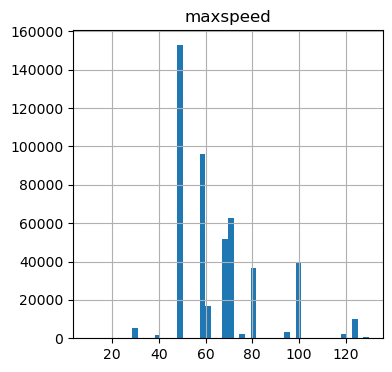

In [18]:
# Number of links (not length) with specified speeds after applying speed limits from params
sm.road_links.hist(column='maxspeed', bins=50, figsize=(4,4))

In [19]:
# Speed limits after applying speed limits from params
sm.road_links['maxspeed'].unique()

array([ 81.        ,  76.        ,  70.        ,  60.        ,
       125.        , 100.        ,  68.        ,  58.        ,
        80.        ,  50.        , 120.        ,  40.        ,
        96.        ,  30.        , 130.        ,  90.        ,
        10.        ,  20.        ,  65.        ,   9.16666667])

Now, generate travel time based on the information available. In many transport models, time depends on the network flow. As a simplification for this long-term strategic model in times of modern traffic management, we assume speed limits to be equilibrated with the traffic situation. Hence, travel time depends on speed limits.

In a [publication by the Federal Environmental Agency](https://www.umweltbundesamt.de/publikationen/klimaschutz-durch-tempolimit), the following average speeds were found on the respective road sections:
- Speed limit | average traffic flow speed 
- <=60 | 60
- 80 | 87.4
- 100 | 103.3
- 120 | 115.6
- 130 | 118.3
- open | 124.7

The following calculations approximate these figures.

In [20]:
# Generate time for road links in seconds
# Manual calibration with Google maps (see below)
# shows that traffic flow is slower than the speed limits

# For up to 60km/h average speed equals the speed limit
mask60 = sm.road_links['maxspeed']<=60
sm.road_links.loc[mask60, 'time'] = sm.road_links['length'] / 1000 \
    / sm.road_links['maxspeed'] * 3600

# Then, up to under 100km/h, average speeds are 10% above the speed limit
mask100 = sm.road_links['maxspeed']<100
sm.road_links.loc[(~mask60)&(mask100), 'time'] = \
    sm.road_links['length'] / 1000 / sm.road_links['maxspeed'] * 3600 * 1.1

# Then, speed follows a polynomial of y = -0,0115x2 + 3,145x - 96,2 (R^2=1)
mask_not_open = sm.road_links['maxspeed']!=125
sm.road_links.loc[(~mask100)&(mask_not_open), 'time'] = sm.road_links['length'] / 1000 / \
    (-0.0115*np.power(sm.road_links['maxspeed'], 2) + 3.145*sm.road_links['maxspeed'] - 96.2) * 3600

# without speed limit
sm.road_links.loc[~mask_not_open, 'time'] = sm.road_links['length'] / 1000 \
    / sm.road_links['maxspeed'] * 3600

assert len(sm.road_links[sm.road_links['time'].isna()])==0
sm.road_links.loc[sm.road_links['time']==0, 'time'] = 1

<Axes: >

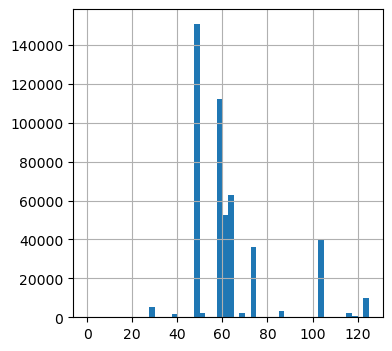

In [21]:
# Average speed by number of links (not length) after applying speed limits from params
(sm.road_links['length'] / 1000 / sm.road_links['time'] * 3600).hist(bins=50, figsize=(4,4))

In [22]:
sm.road_links.head(10)

,a,b,length,maxspeed,lanes,highway,geometry,ref,time
index,,,,,,,,,
rl_1,2836167,2836175,313,81.0,3,motorway_link,"LINESTRING (10.30484 47.68064, 10.30476 47.68158)",None,15.302222
rl_2,2836167,331327683,280,76.0,2,motorway,"LINESTRING (10.30484 47.68064, 10.30109 47.68068)",A 980,14.589474
rl_3,2836175,2981344644,36,81.0,2,motorway_link,"LINESTRING (10.30476 47.68158, 10.30523 47.68149)",A 7,1.760000
rl_4,2836175,2741791236,57,81.0,1,motorway_link,"LINESTRING (10.30476 47.68158, 10.30508 47.68113)",None,2.786667
rl_5,2836179,282393483,40,70.0,4,primary,"LINESTRING (10.30454 47.67961, 10.30466 47.67997)",B 19,2.262857
rl_6,2836179,355571631,67,70.0,2,trunk,"LINESTRING (10.30454 47.67961, 10.30428 47.67903)",B 19,3.790286
rl_7,2836179,60730353,49,81.0,1,motorway_link,"LINESTRING (10.30454 47.67961, 10.30517 47.67950)",None,2.395556
rl_8,2836180,2836179,56,60.0,1,trunk,"LINESTRING (10.30449 47.67911, 10.30454 47.67961)",B 19,3.360000
rl_9,2836180,60730353,70,81.0,1,motorway_link,"LINESTRING (10.30449 47.67911, 10.30517 47.67950)",None,3.422222


### Alter road access/egress links

In [23]:
# Find missing connectors
missing_connectors = set(sm.zones.index) - set(sm.zone_to_road['a'])
islands = ['DE94C_7', 'DE947_2', 'DE947_4', 'DE94H_3',
           'DE94H_4', 'DE94A_2', 'outer_2', 'DEF07_3']
missing_connectors - set(islands)

{'DE80J_5', 'DE937_4'}

In [24]:
# Add missing connectors
ntlegs = engine.ntlegs_from_centroids_and_nodes(
    sm.centroids.loc[list(missing_connectors - set(islands))],
    sm.road_nodes,
    short_leg_speed=params['pt_access']['speed_walk'],
    long_leg_speed=params['pt_access']['speed_bicycle'],
    threshold=params['pt_access']['catchment_radius_walk'],
    n_neighbors=1,
    coordinates_unit=sm.coordinates_unit)
sm.zone_to_road = pd.concat([
    sm.zone_to_road,
    ntlegs[list(set(sm.zone_to_road.columns).intersection(set(ntlegs.columns)))]]
).reset_index(drop=True)

In [25]:
# Drop island road connections (except Sylt) and connect
# them to a virtual single road node
sm.zone_to_road = sm.zone_to_road.loc[~(sm.zone_to_road['a'].isin(islands))
                                      & ~(sm.zone_to_road['b'].isin(islands))]
for i in islands:
    road_node = gpd.GeoDataFrame({'FID': [i]},
                                 index=[i+'_n'],
                                 geometry=[sm.centroids.loc[i, 'geometry']],
                                 crs=sm.epsg)
    ntlegs = engine.ntlegs_from_centroids_and_nodes(
        sm.centroids.loc[[i]],
        road_node,
        short_leg_speed=params['pt_access']['speed_walk'],
        long_leg_speed=params['pt_access']['speed_bicycle'],
        threshold=params['pt_access']['catchment_radius_walk'],
        n_neighbors=1,
        coordinates_unit=sm.coordinates_unit)
    sm.zone_to_road = pd.concat([
        sm.zone_to_road,
        ntlegs[list(set(sm.zone_to_road.columns).intersection(ntlegs.columns))]]
    ).reset_index(drop=True)
    sm.road_nodes = pd.concat([sm.road_nodes,road_node])

In [26]:
# Every zone must be connected
assert len(sm.zone_to_road.loc[sm.zone_to_road['direction']=='access','a'
                              ].unique()) == len(sm.zones.index)

In [27]:
# Assign a time by urbanisation degree
for u in sm.zones['urbanisation'].unique():
    u_zones = sm.zones.loc[sm.zones['urbanisation']==u].index
    sm.zone_to_road.loc[(sm.zone_to_road['a'].isin(u_zones)) | sm.zone_to_road['b'].isin(u_zones),
                        'time'] = params['access-egress_links']['time_road_'+str(u)]

## Apply road pathfinder in order to generate LoS table

In [28]:
# Load OD pairs from volumes if available
od_set = None
try:
    v = stepmodel.read_zippedpickles(
        model_path.replace(scenario, params['general']['parent']) + 'de_volumes')
    od_set = set([tuple(l) for l in v.volumes[['origin', 'destination']].values.tolist()])
    print('Generated OD set with {} pairs'.format(len(od_set)))
except:
    print('The volumes file is not (yet) available')

volumes: 100%|████████████████████████████████████| 1/1 [00:00<00:00,  7.92it/s]


Generated OD set with 201048 pairs


In [29]:
sm.step_road_pathfinder(all_or_nothing=True,
                        od_set=od_set)

self.volumes does not exist. od generated with self.zones
 'all_or_nothing'=True is deprecated. use method = 'aon' instead


In [30]:
sm.car_los.sample()

,origin,destination,time,path,gtime
76732,DED45_6,DED42_2,5317.674646,"[DED45_6, 5423102627, 5429607963, 5423102678, ...",5317.674646


In [31]:
# Drop inner-cell connections
sm.car_los = sm.car_los[sm.car_los['origin']!=sm.car_los['destination']]
sm.car_los.shape

(198841, 5)

In [32]:
# Drop non-existent island connections
sm.car_los = sm.car_los.drop(sm.car_los.loc[(sm.car_los['time']==np.inf)].index)
len(sm.car_los)

198841

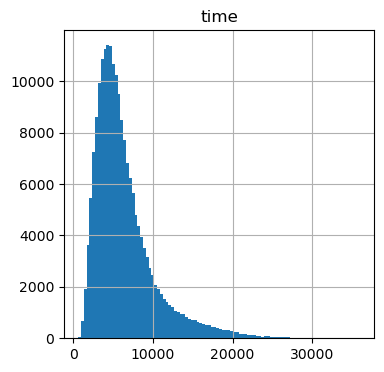

In [33]:
if manual: sm.car_los.hist(column='time', bins=100, figsize=(4,4))

## Add various attributes to LoS table

In [34]:
sm.analysis_car_los()

In [35]:
# Disaggregate into in-vehicle time and access/egress
sm.car_los['access_time'] = sm.car_los['origin'].map(
    sm.zone_to_road.drop_duplicates('a').set_index('a')['time'])
sm.car_los['in_vehicle_time'] = sm.car_los['time'] - sm.car_los['access_time']

In [36]:
# Add distances car
if not 'length' in sm.road_links.columns:
    sm.road_links['length'] = skims.distance_from_geometry(sm.road_links['geometry']).astype(int)
len_dict = sm.road_links['length'].to_dict()
sm.car_los['length'] = sm.car_los['link_path'].apply(lambda p: sum([len_dict[l] for l in p]))

In [37]:
# Add route_type = 'car' in car_los
sm.car_los['route_type'] = 'car'
sm.car_los['route_types'] = [(t,) for t in sm.car_los['route_type']]

In [38]:
#sm.car_los['ntransfers'] = 0

In [39]:
# Verify with Google maps routing
# Berlin (DE300) - Stade (DE939): 4h22m, 354km
# Berlin (DE300) - Stuttgart (DE111): 6h37m, 632km
# Berlin (DE300) - Stendal (DEE0D): 2h08m, 125km
# Stade (DE939) - Stuttgart (DE111): 7h45m, 687km
# Stendal (DEE0D) - Stuttgart (DE111): 6h11m, 574km
# Stendal (DEE0D) - Stade (DE939): 3h22m, 231km
od = ['DE300_0', 'DE939_6', 'DE111_0', 'DEE0D_2']
for _, row in sm.car_los.loc[(sm.car_los['origin'].isin(od)) &
                             (sm.car_los['destination'].isin(od))].iterrows():
    print(row['origin'] + ' - ' + row['destination'] + ': '
          + str(np.round(row['time']/3600,1)) + ', '
          + str(int(sm.road_links.loc[row['link_path'], 'length'].sum()/1000)) + 'km')

DE300_0 - DE111_0: 5.6, 631km
DE300_0 - DEE0D_2: 2.6, 199km
DE300_0 - DE939_6: 4.1, 339km
DEE0D_2 - DE111_0: 6.1, 630km
DE939_6 - DE300_0: 4.1, 353km
DEE0D_2 - DE300_0: 2.7, 200km
DE111_0 - DE300_0: 5.6, 631km


## Save model

In [40]:
# Ditch unneccessary columns
to_drop = ['alighting_links','alightings','all_walk','boarding_links','boardings',
           'footpaths','length_link_path','node_path','ntlegs','time_link_path','transfers',
           'pathfinder_session','gtime','reversed', 'broken_modes', 'path']
sm.car_los = sm.car_los.drop(to_drop, axis=1, errors='ignore')

In [41]:
sm.car_los.columns

Index(['origin', 'destination', 'time', 'link_path', 'access_time',
       'in_vehicle_time', 'length', 'route_type', 'route_types'],
      dtype='object')

In [42]:
assert sm.car_los.isna().any(axis=1).max() == 0

In [43]:
# Make table smaller
cols = ['time', 'access_time', 'in_vehicle_time', 'length']
sm.car_los[cols] = sm.car_los[cols].astype(int)

In [44]:
sm.to_zippedpickles(model_path + 'de_road_los', only_attributes=['car_los'])

car_los: 100%|██████████████████████████████████| 13/13 [00:10<00:00,  1.24it/s]


In [45]:
# Save distances between centroids
if params['general']['od_sparse_sample'] == 0 \
        or not os.path.exists(output_path + 'distances_centroids.csv'):
    (sm.car_los.groupby(['origin', 'destination']).agg({'length': 'mean'}) / 1000
    ).astype(int).to_csv(output_path + 'distances_centroids.csv')